# Neural Decision Trees and Forests for Predictive Lead Scoring

The contents of this notebook depict an application of neural decision trees and forests to a sales dataset for a mortgage lending company. The goal in using this dataset is to predict whether or not the sales lead will submit an application for a mortgage based on the following 10 features:


1.   Timestamp at which the lead was generated
2.   Whether the potential customer was looking to refinance a mortgage or purchase a new home
3.   Cost of the lead
4.   State in which the lead was generated
5.   Loan amount desired
6.   Loan to value amount
7.   Whether there would be any cash out involved  
8.   What the amount of any potential cash out would be
9.   The customer's self-reported credit score
10.  The customer's estimated credit score

Once those predictions are made, a more targeted sales strategy can be taken by the company. By only targeting those leads that have a greater than 50% probability of submitting an application, the overall cost for lead acquisition should be reduced while the application rate increases. 

# Packages

---

---








In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Loading and Preprocessing

---

---





## Functions

In [ ]:
# since not all states are present in the dataset, the states are instead mapped to a specific region within the country
def region(state):
  if state in western_states:
    return 'western'
  elif state in midwestern_states:
    return 'midwestern'
  elif state in southern_states:
    return 'southern'
  else: return 'northeastern'

## Loading

In [ ]:
data = pd.read_excel('Better_Case_Raw_Data_(1).xlsx')
data['Year'] = data.LEAD_CREATED_TIMESTAMP.dt.year
data['Month'] = data.LEAD_CREATED_TIMESTAMP.dt.month
data['Date'] = data.LEAD_CREATED_TIMESTAMP.dt.day
data['Time'] = data.LEAD_CREATED_TIMESTAMP.dt.time
data.columns = [col.lower() for col in data.columns]
data.drop(['lead_created_timestamp', 'user_id','lead','account',
           'fund','lock','denied','year'],axis = 1, inplace = True)
data.cashout_amt = data.cashout_amt.fillna(0)
data.head()

,mortgage_type,cost,state,loan_amt,loan_to_value,is_cashout,cashout_amt,self_reported_credit,est_credit_score,application,month,date,time
0,purchase,40,NJ,157500.0,70.0,0,0.0,EXCELLENT,759,0,1,11,15:33:54.464000
1,purchase,41,NC,202500.0,90.0,0,0.0,EXCELLENT,729,0,1,11,15:34:01.316000
2,purchase,46,CO,427500.0,90.0,0,0.0,EXCELLENT,699,0,1,11,15:35:56.270000
3,purchase,40,NJ,202500.0,90.0,0,0.0,EXCELLENT,769,0,1,11,15:41:03.710000
4,purchase,49,TX,180500.0,95.0,0,0.0,EXCELLENT,739,0,1,11,15:41:23.959000


## Preprocessing

In [ ]:
western_states = ['AK','AZ','CA','CO',
                  'HI','ID','MT','NV',
                  'NM','OR','UT','WA',
                  'WY']

midwestern_states = ['IL','IN','IA','KS',
                     'MI','MO','MN','NE',
                     'ND','OH','SD','WI']

southern_states = ['AL','AR','DC','DE',
                   'FL','GA','KY','LA',
                   'MD','MS','NC','OK',
                   'SC','TN','TX','VA',
                   'WV']

northeastern_states = ['CT','MA','ME','NH',
                       'NJ','NY','RI','PA',
                       'VT']

# mapping to state to one of four regions
data['region'] = data.state.apply(region)

# breaking timestamp down into hour and whether or not the application was submitted before noon
data['hour'] = data.time.apply(lambda x: x.hour)
data['am'] = data.hour.apply(lambda x: 'yes' if x < 12 else 'no')

# changing binary encoded variables to text
data['is_cashout'] = data.is_cashout.apply(lambda x: 'yes' if x==1 else 'no')
data['application'] = data.application.apply(lambda x: 'yes' if x==1 else 'no')

# sine and cosine transformations of time variables
data['hour_sin'] = np.sin(2 * np.pi * data.hour/23.)
data['hour_cos'] = np.cos(2 * np.pi * data.hour/23.)
data['month_sin'] = np.sin(2 * np.pi * data.month/12.)
data['month_cos'] = np.cos(2 * np.pi * data.month/12.)
data['date_sin'] = np.sin(2 * np.pi * data.date/31.)
data['date_cos'] = np.cos(2 * np.pi * data.date/31.)

# creating a handful of new features
data['loan_to_credit'] = data.loan_amt / data.est_credit_score
data['cost_to_credit'] = data.cost / data.est_credit_score
data['loan_to_cost'] = data.loan_amt / data.cost
data['ltv_credit_score'] = data.loan_to_value * data.est_credit_score

# removing columns that are no longer needed
data.drop(['month','date','time','hour'], axis = 1, inplace = True)
data.head()

,mortgage_type,cost,state,loan_amt,loan_to_value,is_cashout,cashout_amt,self_reported_credit,est_credit_score,application,region,am,hour_sin,hour_cos,month_sin,month_cos,date_sin,date_cos,loan_to_credit,cost_to_credit,loan_to_cost,ltv_credit_score
0,purchase,40,NJ,157500.0,70.0,no,0.0,EXCELLENT,759,no,northeastern,no,-0.81697,-0.57668,0.5,0.866025,0.790776,-0.612106,207.509881,0.052701,3937.500000,53130.0
1,purchase,41,NC,202500.0,90.0,no,0.0,EXCELLENT,729,no,southern,no,-0.81697,-0.57668,0.5,0.866025,0.790776,-0.612106,277.777778,0.056241,4939.024390,65610.0
2,purchase,46,CO,427500.0,90.0,no,0.0,EXCELLENT,699,no,western,no,-0.81697,-0.57668,0.5,0.866025,0.790776,-0.612106,611.587983,0.065808,9293.478261,62910.0
3,purchase,40,NJ,202500.0,90.0,no,0.0,EXCELLENT,769,no,northeastern,no,-0.81697,-0.57668,0.5,0.866025,0.790776,-0.612106,263.328999,0.052016,5062.500000,69210.0
4,purchase,49,TX,180500.0,95.0,no,0.0,EXCELLENT,739,no,southern,no,-0.81697,-0.57668,0.5,0.866025,0.790776,-0.612106,244.248985,0.066306,3683.673469,70205.0


To better capture the cyclic nature of the *Month*, *Date*, and *Hour* variables in this dataset, sine and cosine transformations are applied to them. The plots below demonstrate the results of these transformations.

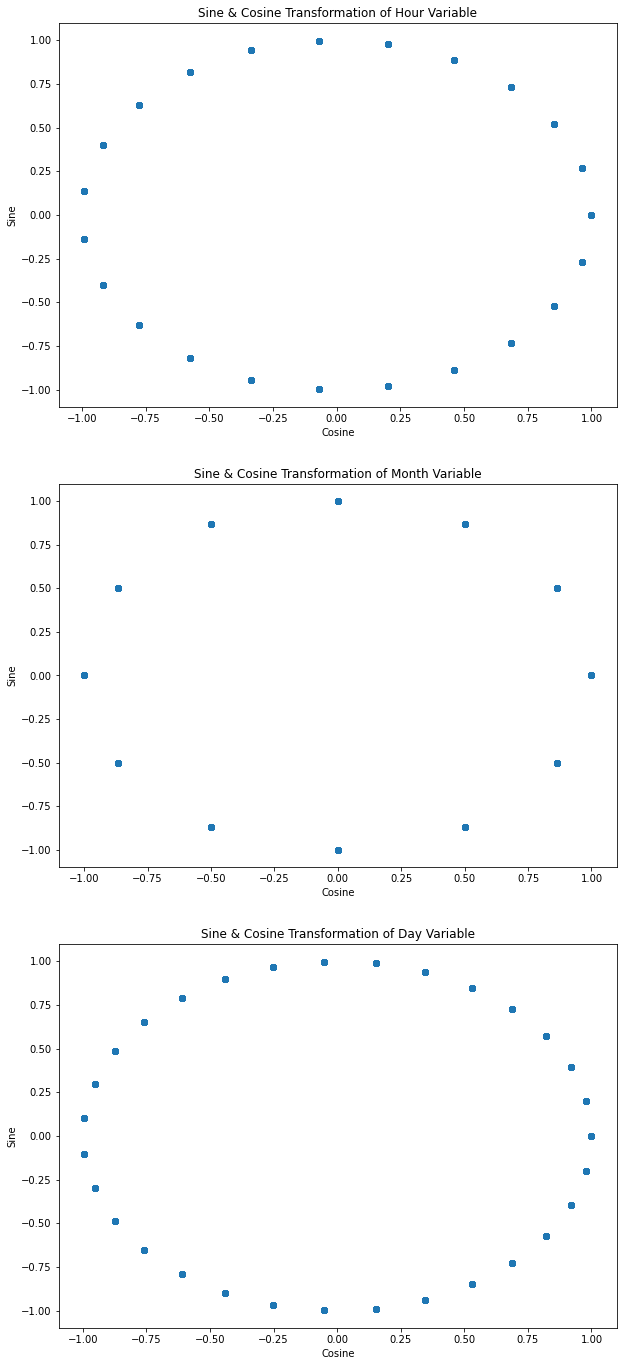

In [ ]:
fig, axs = plt.subplots(3,1,figsize=(10,24))

_ = axs[0].scatter(data.hour_cos, data.hour_sin)
_ = axs[0].set_title('Sine & Cosine Transformation of Hour Variable')
_ = axs[0].set_xlabel('Cosine')
_ = axs[0].set_ylabel('Sine')

_ = axs[1].scatter(data.month_cos, data.month_sin)
_ = axs[1].set_title('Sine & Cosine Transformation of Month Variable')
_ = axs[1].set_xlabel('Cosine')
_ = axs[1].set_ylabel('Sine')

_ = axs[2].scatter(data.date_cos, data.date_sin)
_ = axs[2].set_title('Sine & Cosine Transformation of Day Variable')
_ = axs[2].set_xlabel('Cosine')
_ = axs[2].set_ylabel('Sine')

In [ ]:
no_application, application = data.application.value_counts(normalize=True)[0], data.application.value_counts(normalize=True)[1]
no_application *= 100
application *= 100
print(f'Percentage of Leads that Submitted an Application      : {round(application,2)}')
print(f'Percentage of Leads that Did Not Submit an Application : {round(no_application,2)}')

Percentage of Leads that Submitted an Application      : 3.82
Percentage of Leads that Did Not Submit an Application : 96.18


The target variable in this dataset - whether or not an application for a mortgage was submitted - is highly imbalanced, with about 96% of the sales leads in the dataset failing to submit a mortgage application and only about 4% of sales leads actually submitting an application. In the modeling portion of the notebook, a couple of different approaches to handling this class imbalance will be tested.

Lists of numeric and categorical features are created here. For the categorical features, a vocabulary for each feature's categories is created. This vocabulary will be put to use when feeding the training dataset into the neural decision tree or neural decision forest at training time. 

In [ ]:
FEATURE_NAMES = [
    "cost",
    "loan_amt",
    "loan_to_value",
    "cashout_amt",
    "est_credit_score",
    "hour_sin",
    "hour_cos",
    "loan_to_credit",
    "cost_to_credit",
    "loan_to_cost",
    "ltv_credit_score",
    "month_sin",
    "month_cos",
    "date_sin",
    "date_cos",
    "mortgage_type",
    "state",
    "self_reported_credit",
    "region",
    "am",
    "is_cashout",          
]


CSV_HEADER = FEATURE_NAMES + ['application']

NUM_FEATURE_NAMES = [
    "cost",
    "loan_amt",
    "loan_to_value",
    "cashout_amt",
    "est_credit_score",
    "hour_sin",
    "hour_cos",
    "loan_to_credit",
    "cost_to_credit",
    "loan_to_cost",
    "ltv_credit_score",
    "month_sin",
    "month_cos",
    "date_sin",
    "date_cos",
]


CAT_FEATURES_WITH_VOCAB = {
    "mortgage_type": sorted(list(data["mortgage_type"].unique())),
    "state": sorted(list(data["state"].unique())),
    "self_reported_credit": sorted(list(data["self_reported_credit"].unique())),
    "region": sorted(list(data["region"].unique())),
    "am": sorted(list(data["am"].unique())),
    "is_cashout": sorted(list(data["is_cashout"].unique())),
}

CAT_FEATURE_NAMES = list(CAT_FEATURES_WITH_VOCAB.keys())

FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUM_FEATURE_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]


TARGET_FEATURE_NAME = "application"

TARGET_LABELS = ["no", "yes"]

The last part of the *Preprocessing* section is the creation of boxplots for each of the variables in the dataset, grouped by target class. These plots provide a visualization of natural differences in the numeric variables based upon whether or not a mortgage application was submitted. First, the numeric variables.

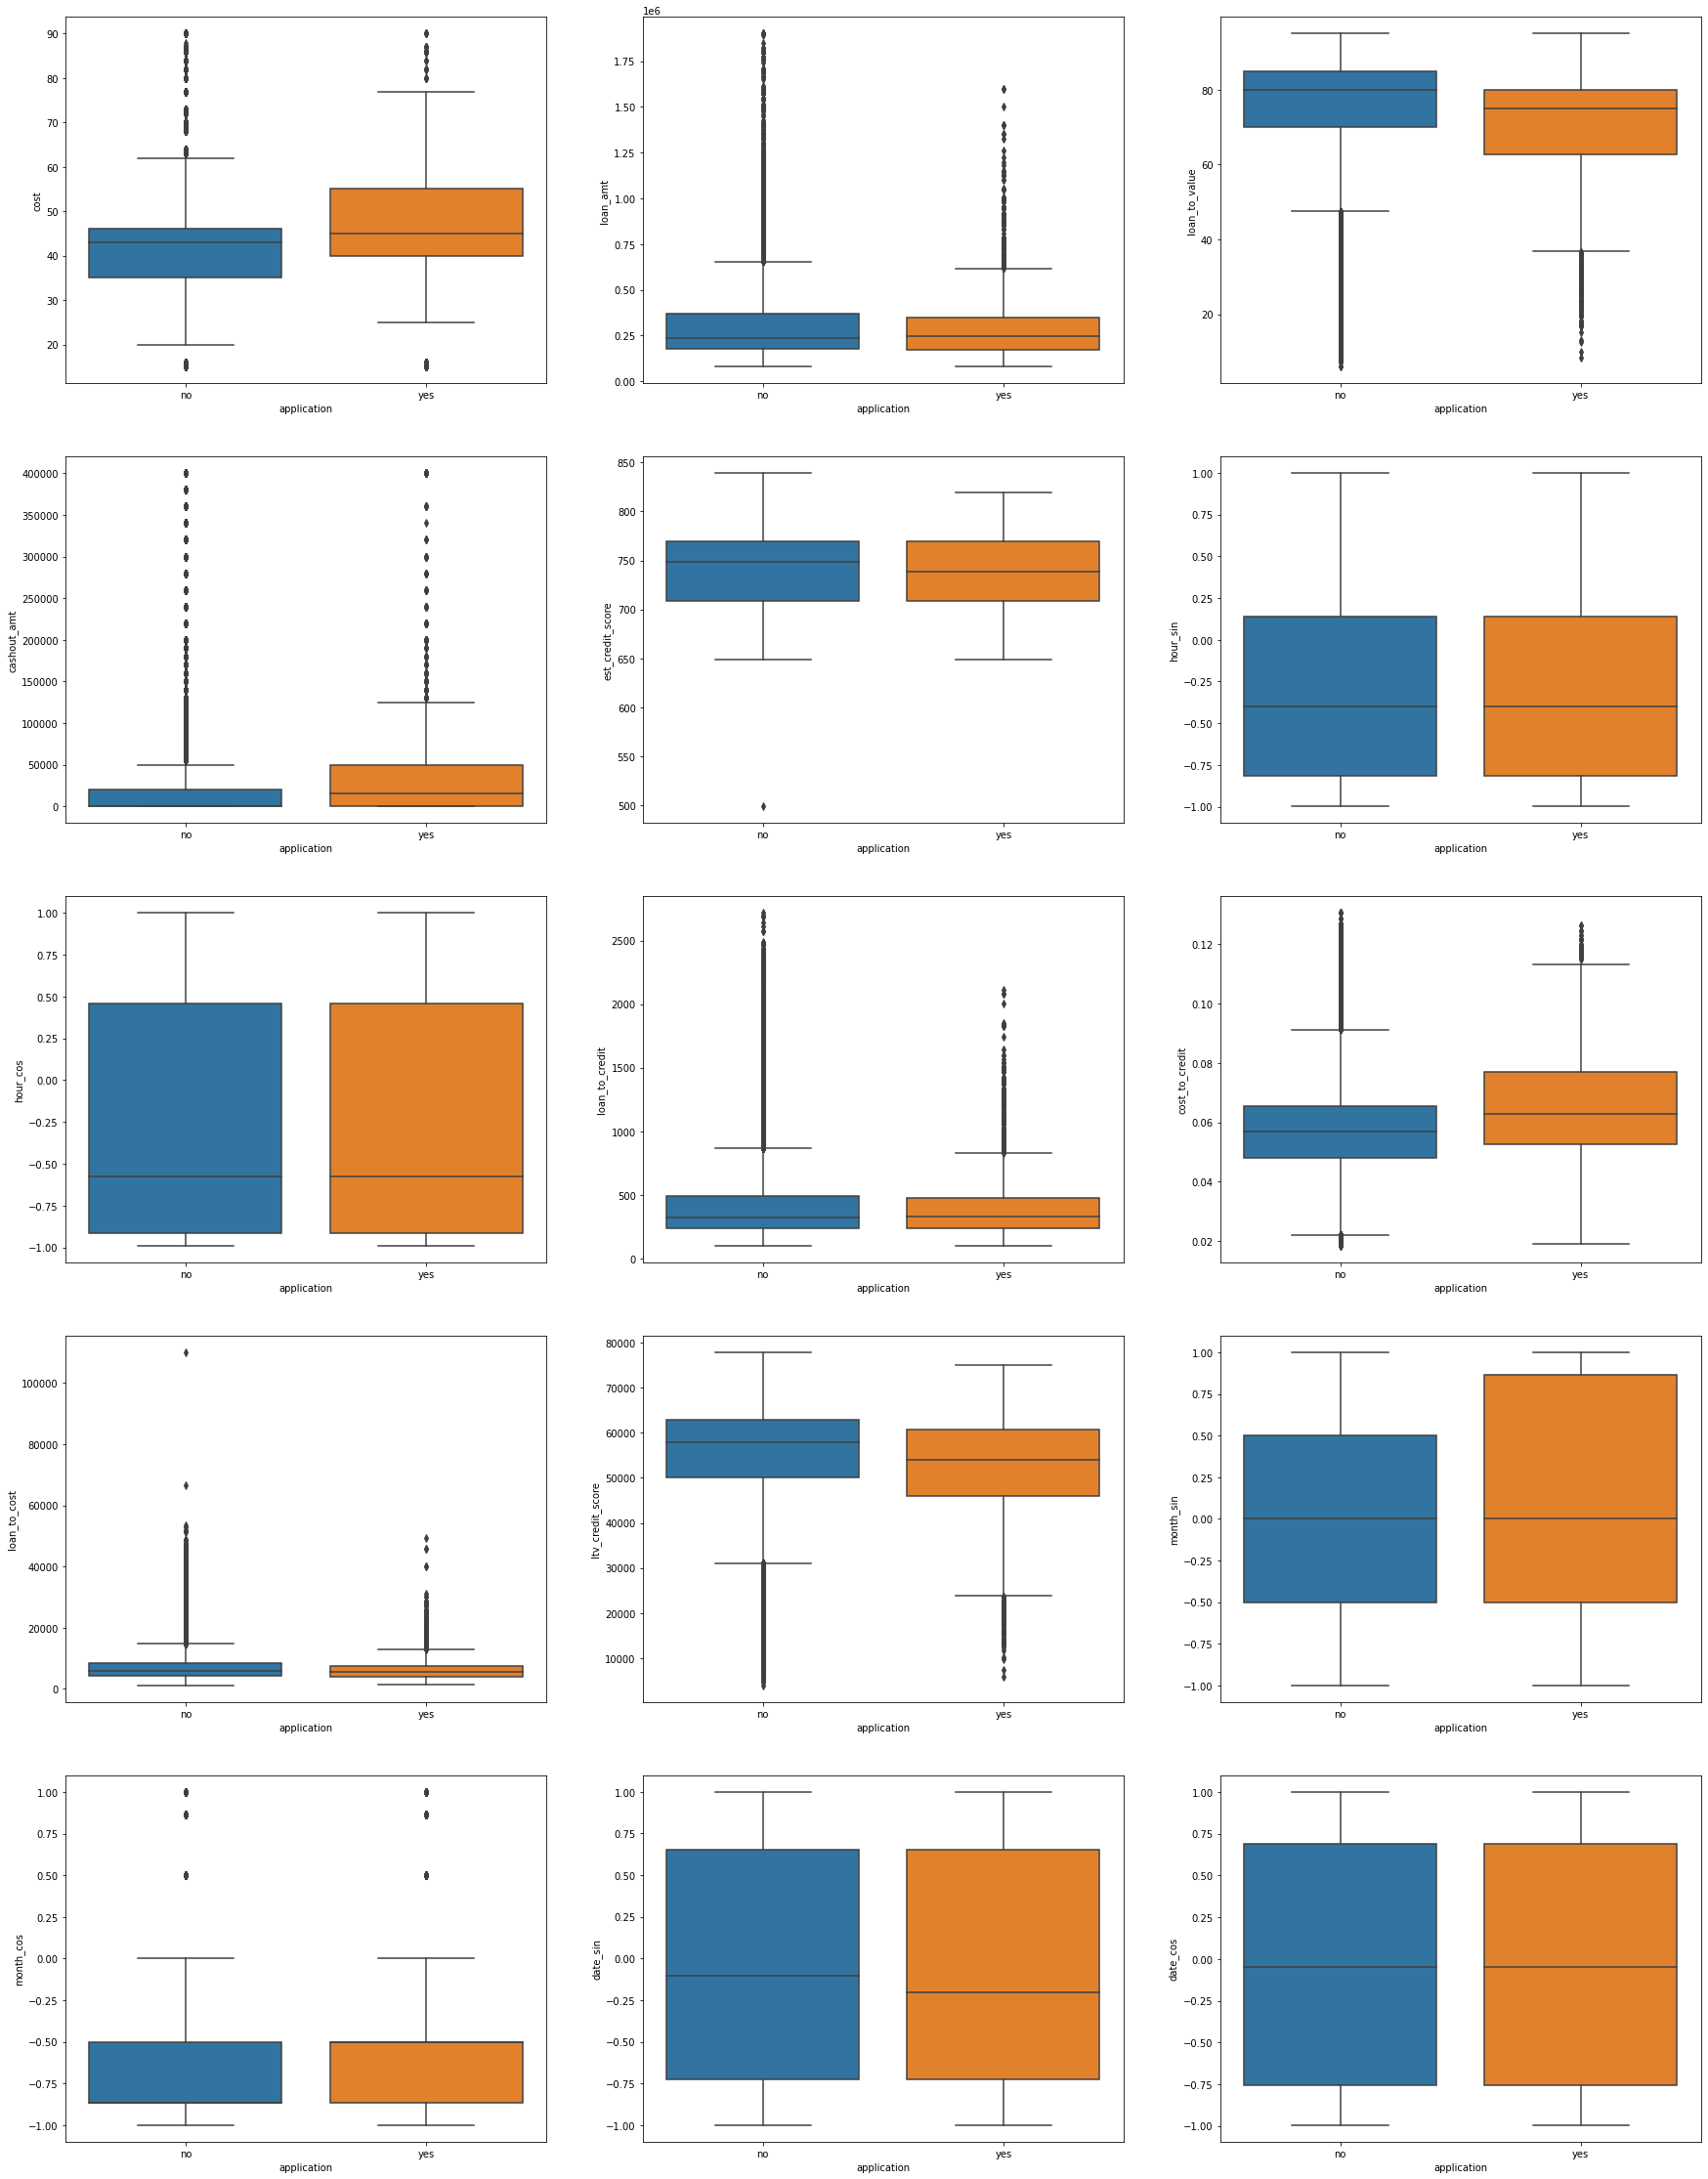

In [ ]:
fig, axs = plt.subplots(5, 3, figsize = (30,40))
axs = axs.flatten()
for i, var in enumerate(NUM_FEATURE_NAMES):
  sns.boxplot(x = 'application', y = var, data = data, orient = 'v', ax = axs[i])

Next, the categorical variables.

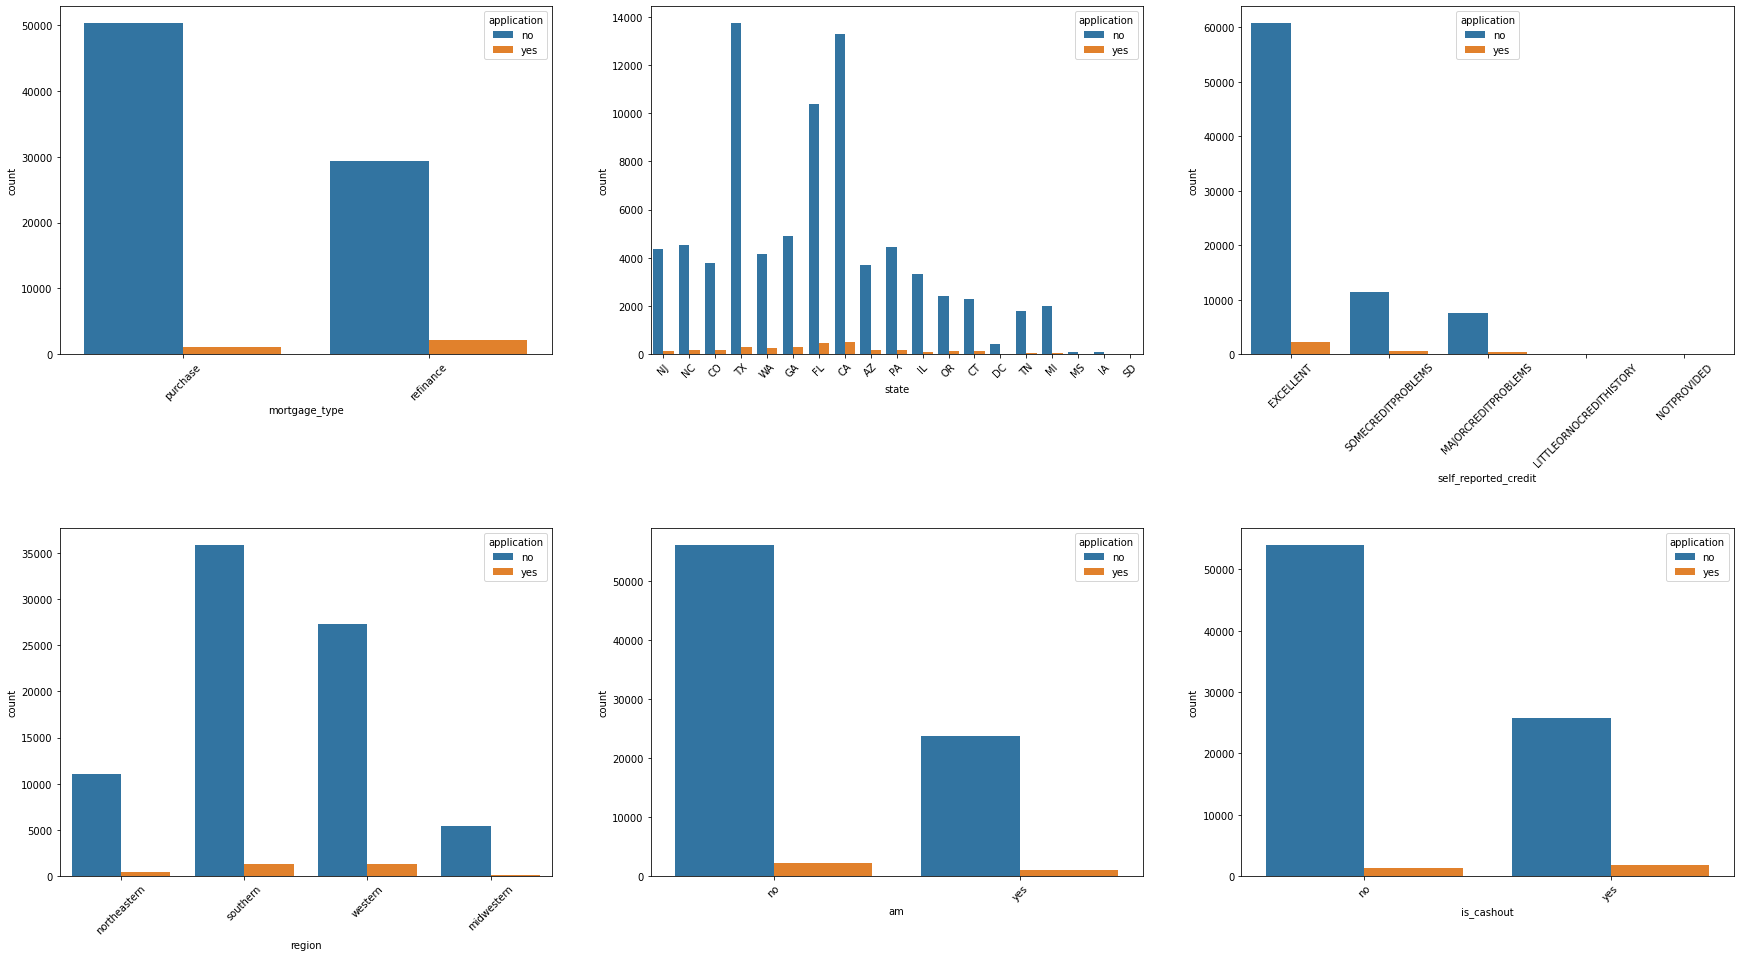

In [ ]:
fig, axs = plt.subplots(2, 3, figsize = (30,16))
axs = axs.flatten()
for i, var in enumerate(CAT_FEATURE_NAMES):
  sns.countplot(x = var, hue='application', data = data, ax = axs[i])
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace=0.5)

# Modeling Setup

---

---





## Modeling Functions

In [ ]:
# creates an input dictionary into which the training dataset is passed
def create_model_inputs():
  inputs={}
  for feature_name in FEATURE_NAMES:
    if feature_name in NUM_FEATURE_NAMES:
      inputs[feature_name] = tf.keras.layers.Input(
          name=feature_name, shape=(), dtype=tf.float32
      )
    else:
      inputs[feature_name] = tf.keras.layers.Input(
          name=feature_name, shape=(), dtype=tf.string
      )
  
  return inputs


# encodes the features passed through the input dictionary depending upon their dtype
def encode_inputs(inputs, use_embedding=False):
  encoded_features=[]
  for feature_name in inputs:
    if feature_name in CAT_FEATURE_NAMES:
      vocabulary = CAT_FEATURES_WITH_VOCAB[feature_name]

      index = tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=vocabulary, mask_token=None, num_oov_indices=0
      )
      value_index = index(inputs[feature_name])
      if use_embedding:
        embedding_dims = int(math.sqrt(len(vocabulary)))
        embedding_encoder = tf.keras.layers.Embedding(
            input_dim=len(vocabulary), output_dim=embedding_dims
        )
        encoded_feature = embedding_encoder(value_index)
      else:
        onehot_encoder = tf.keras.layers.experimental.preprocessing.CategoryEncoding(output_mode='binary')
        onehot_encoder.adapt(index(vocabulary))
        encoded_feature = onehot_encoder(value_index)
    else:
      encoded_feature = inputs[feature_name]
      if inputs[feature_name].shape[-1] is None:
        encoded_feature = tf.expand_dims(encoded_feature, -1)

    encoded_features.append(encoded_feature)

  encoded_features = tf.keras.layers.concatenate(encoded_features)
  return encoded_features


# takes an already created model, compiles it, trains it, and evaluates it on the test data
# has an option to include class weights for model training 
def run_experiment(model, class_weights=None):

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  print('Initiating model training...')
  train_dataset = get_dataset_from_csv('train_data.csv', shuffle=True, batch_size=batch_size)

  if class_weights is not None:
    model.fit(train_dataset, epochs=num_epochs, class_weight=class_weights)
    print('Model training finished.\n')

  else:
    model.fit(train_dataset, epochs=num_epochs)
    print('Model training finished.\n')

  print('Evaluating model performance on test set...')
  test_dataset = get_dataset_from_csv('test_data.csv', batch_size=batch_size)

  _, accuracy = model.evaluate(test_dataset)
  print(f'Test accuracy: {round(accuracy*100,2)}%')

  preds = model.predict(test_dataset)
  return preds


# loads csv dataset from specified file path and formats it for modeling
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
  dataset = tf.data.experimental.make_csv_dataset(
      csv_file_path,
      batch_size=batch_size,
      column_names=CSV_HEADER,
      column_defaults=COLUMN_DEFAULTS,
      label_name=TARGET_FEATURE_NAME,
      num_epochs=1,
      header=False,
      na_value='?',
      shuffle=shuffle
  ).map(lambda features, target: (features, target_label_lookup(target)))
  
  return dataset


# creates a neural decision tree model based upon already specified hyperparameters 
def create_tree_model():
  inputs = create_model_inputs()
  features = encode_inputs(inputs, use_embedding=True)
  features = tf.keras.layers.BatchNormalization()(features)
  num_features = features.shape[1]

  tree = NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)

  outputs = tree(features)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model


# creates a neural decision forest model based upon already specified hyperparameters
def create_forest_model():
  inputs = create_model_inputs()
  features = encode_inputs(inputs, use_embedding=True)
  features = tf.keras.layers.BatchNormalization()(features)
  num_features = features.shape[1]

  forest_model = NeuralDecisionForest(num_trees, depth, num_features, used_features_rate, num_classes)

  outputs = forest_model(features)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

## Classes

In [ ]:
# neural decision tree model class
class NeuralDecisionTree(tf.keras.Model):
  def __init__(self, depth, num_features, used_features_rate, num_classes):
    super(NeuralDecisionTree, self).__init__()
    self.depth = depth
    self.num_leaves = 2**depth
    self.num_classes = num_classes

    num_used_features = int(num_features * used_features_rate)
    one_hot = np.eye(num_features)
    sampled_feature_indices = np.random.choice(np.arange(num_features), num_used_features, replace=False)
    self.used_features_mask = one_hot[sampled_feature_indices]

    self.pi = tf.Variable(
        initial_value=tf.random_normal_initializer()(
            shape=[self.num_leaves, self.num_classes]
        ),
        dtype='float32',
        trainable=True
    )

    self.decision_fn = tf.keras.layers.Dense(
        units=self.num_leaves, activation='sigmoid', name='decision'
    )

  def call(self, features):
    batch_size = tf.shape(features)[0]

    features = tf.matmul(
        features, self.used_features_mask, transpose_b=True
    )
    decisions = tf.expand_dims(
        self.decision_fn(features), axis=2
    )
    decisions = tf.keras.layers.concatenate(
        [decisions, 1-decisions], axis=2
    )

    mu = tf.ones([batch_size, 1, 1])

    begin_idx=1
    end_idx=2
    for level in range(self.depth):
      mu = tf.reshape(mu, [batch_size, -1, 1])
      mu = tf.tile(mu, (1, 1, 2))
      level_decisions = decisions[
                                  :, begin_idx:end_idx, :
      ]
      mu = mu*level_decisions
      begin_idx = end_idx
      end_idx = begin_idx + 2**(level+1)

    mu = tf.reshape(mu, [batch_size, self.num_leaves])
    probabilities = tf.keras.activations.softmax(self.pi)
    outputs = tf.matmul(mu, probabilities)
    return outputs


# neural decision forest model class
class NeuralDecisionForest(tf.keras.Model):
  def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
    super(NeuralDecisionForest, self).__init__()
    self.ensemble=[]

    for _ in range(num_trees):
      self.ensemble.append(
          NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
      )

  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]
    outputs = tf.zeros([batch_size, num_classes])

    for tree in self.ensemble:
      outputs += tree(inputs)
    
    outputs /= len(self.ensemble)
    return outputs

# Modeling

To combat the class imbalance problem in the *application* target variable, three different methods of handling such an imbalance will be tried. The first of these methods is class weighting - without removing any of the samples in the dataset or synthesizing any new samples, the target classes will be weighted by the frequency with which they appear in the training data. Ideally, these weightings will enable the model to "pay more attention to" the minority class than it would have otherwise, thereby enabling the model to learn the features of both classes instead of just the features of the majority class.

The next two methods that will be tested are undersampling and oversampling. Undersampling refers to the process of reducing the majority class to a random selected subset of the class. The size of the subset will be proportional to the original size of the minority class, the idea being that the newly balanced dataset will maintain enough samples from the original majority class for the model to still be able to learn the features of that class. 

Oversampling does the opposite - it randomly selects samples from the minority class to duplicate, and it continues to do this until the size of the minority class matches the original size of the majority class. The benefit of sampling with this method is that the resultant dataset still contains all of the information present in the original majority class, and it now also contains a highly amplified version of the information within the original minority class.

## Weighted Data

---

---





### Data Preparation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[FEATURE_NAMES], data.application, test_size=0.2, stratify=data.application)
train_data = pd.concat([X_train, y_train],axis=1,ignore_index=True)
train_data.columns = FEATURE_NAMES + ['application']
train_data.to_csv('train_data.csv', index=False, header=False, encoding='utf-8')

test_data = pd.concat([X_test, y_test],axis=1,ignore_index=True)
test_data.to_csv('test_data.csv', index=False, header=False, encoding='utf-8')

weight_for_0 = 1/len(train_data[train_data.iloc[:,-1]=='no'])*len(train_data)/2
weight_for_1 = 1/len(train_data[train_data.iloc[:,-1]=='yes'])*len(train_data)/2
print(f'Negative Class Weight: {weight_for_0}')
print(f'Positive Class Weight: {weight_for_1}')

Negative Class Weight: 0.5198479266285176
Positive Class Weight: 13.095774091627172


The positive class weight here is over 25 times higher than the negative class weight, which makes sense given the original 4%-96% split of the dataset.

In [ ]:
# model hyperparameters
learning_rate=0.01
batch_size=265
num_epochs=10
hidden_units=[64,64]

num_trees=10
depth=10
used_features_rate=1.0
num_classes=len(TARGET_LABELS)

class_weight = {0: weight_for_0, 1: weight_for_1}


target_label_lookup = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)

First, a neural decision tree is trained with the hyperparameters specified above, including the calculated class weights, and then evaluated on the test set. Following that, a neural decision forest is also trained and evaluated. 

### Neural Decision Tree

In [ ]:
tree_model = create_tree_model()
test_preds_weighted_tree = run_experiment(tree_model, class_weight)

test_class_preds_weighted_tree = [np.argmax(pred) for pred in test_preds_weighted_tree]
tsd = pd.read_csv('test_data.csv',header=None)
tsd.columns = CSV_HEADER
tsd.application = tsd.application.apply(lambda x: 0 if x=='no' else 1)
true_labels = tsd.application.values
roc_auc_preds = [pred[1] for pred in test_preds_weighted_tree]
print(f'AUC: {roc_auc_score(true_labels, roc_auc_preds)}\n')
print('Classification Report:')
print(classification_report(true_labels, test_class_preds_weighted_tree))

Initiating model training...
Epoch 1/10
251/251 [==============================] - 7s 11ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.6525
Epoch 2/10
251/251 [==============================] - 3s 11ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.6087
Epoch 3/10
251/251 [==============================] - 3s 11ms/step - loss: 0.6515 - sparse_categorical_accuracy: 0.6071
Epoch 4/10
251/251 [==============================] - 3s 11ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.6033
Epoch 5/10
251/251 [==============================] - 3s 11ms/step - loss: 0.6463 - sparse_categorical_accuracy: 0.6071
Epoch 6/10
251/251 [==============================] - 3s 11ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.6137
Epoch 7/10
251/251 [==============================] - 3s 11ms/step - loss: 0.6262 - sparse_categorical_accuracy: 0.6289
Epoch 8/10
251/251 [==============================] - 3s 11ms/step - loss: 0.6174 - sparse_categorical_accuracy: 0.6452
Epoch 9/10


### Neural Decision Forest

In [ ]:
forest_model = create_forest_model()
test_preds_weighted_forest = run_experiment(forest_model, class_weight)

test_class_preds_weighted_forest = [np.argmax(pred) for pred in test_preds_weighted_forest]
tsd = pd.read_csv('test_data.csv',header=None)
tsd.columns = CSV_HEADER
tsd.application = tsd.application.apply(lambda x: 0 if x=='no' else 1)
true_labels = tsd.application.values
roc_auc_preds = [pred[1] for pred in test_preds_weighted_forest]
print(f'AUC: {roc_auc_score(true_labels, roc_auc_preds)}\n')
print('Classification Report:')
print(classification_report(true_labels, test_class_preds_weighted_forest))

Initiating model training...
Epoch 1/10
251/251 [==============================] - 15s 28ms/step - loss: 0.6760 - sparse_categorical_accuracy: 0.4923
Epoch 2/10
251/251 [==============================] - 7s 28ms/step - loss: 0.6554 - sparse_categorical_accuracy: 0.6035
Epoch 3/10
251/251 [==============================] - 7s 28ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.5895
Epoch 4/10
251/251 [==============================] - 7s 28ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.6002
Epoch 5/10
251/251 [==============================] - 7s 28ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.6142
Epoch 6/10
251/251 [==============================] - 7s 28ms/step - loss: 0.6232 - sparse_categorical_accuracy: 0.6264
Epoch 7/10
251/251 [==============================] - 7s 28ms/step - loss: 0.6152 - sparse_categorical_accuracy: 0.6431
Epoch 8/10
251/251 [==============================] - 7s 28ms/step - loss: 0.5828 - sparse_categorical_accuracy: 0.6727
Epoch 9/10

Neither of these models proves to perform particularly well. The neural decision tree performs slightly worse, achieving a test set accuracy of roughly 66% and an AUC of only about 0.66. The neural decision forest turns out to be a bit better, landing a test set accuracy of 73%. It's AUC doesn't really improve at all, though, remaining at around 0.67. It appears that the weighting of the classes didn't do all that much, especially since precision for the positive class was only 0.06 for the neural decision tree and 0.07 neural decision forest.   

## Undersampled Data

---

---





### Data Preparation

In [ ]:
# undersampling of the majority class in the training data such that the final dataset is
# split 63/35 between the original majority and minority classes
X_train, X_test, y_train, y_test = train_test_split(data[FEATURE_NAMES], data.application, test_size=0.2, stratify=data.application)
under = RandomUnderSampler(sampling_strategy=0.35)
under_sampled_X, under_sampled_y = under.fit_sample(X_train, y_train) 


train_data = pd.concat([pd.DataFrame(under_sampled_X), pd.DataFrame(under_sampled_y)],axis=1,ignore_index=True)
train_data.columns = FEATURE_NAMES + ['application']
train_data.to_csv('train_data.csv', index=False, header=False, encoding='utf-8')

test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)],axis=1,ignore_index=True)
test_data.to_csv('test_data.csv', index=False, header=False, encoding='utf-8')

In [ ]:
# model hyperparameters
learning_rate=0.01
batch_size=265
num_epochs=10
hidden_units=[64,64]

num_trees=10
depth=10
used_features_rate=1.0
num_classes=len(TARGET_LABELS)


target_label_lookup = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)

### Neural Decision Tree

In [ ]:
tree_model = create_tree_model()
test_preds_undersampled_tree = run_experiment(tree_model)

test_class_preds_undersampled_tree = [np.argmax(pred) for pred in test_preds_undersampled_tree]
tsd = pd.read_csv('test_data.csv',header=None)
tsd.columns = CSV_HEADER
tsd.application = tsd.application.apply(lambda x: 0 if x=='no' else 1)
true_labels = tsd.application.values
roc_auc_preds = [pred[1] for pred in test_preds_undersampled_tree]
print(f'AUC: {roc_auc_score(true_labels, roc_auc_preds)}\n')
print('Classification Report:')
print(classification_report(true_labels, test_class_preds_undersampled_tree))

Initiating model training...
Epoch 1/10
37/37 [==============================] - 2s 8ms/step - loss: 0.6516 - sparse_categorical_accuracy: 0.6842
Epoch 2/10
37/37 [==============================] - 0s 8ms/step - loss: 0.5458 - sparse_categorical_accuracy: 0.7421
Epoch 3/10
37/37 [==============================] - 0s 8ms/step - loss: 0.5284 - sparse_categorical_accuracy: 0.7403
Epoch 4/10
37/37 [==============================] - 0s 8ms/step - loss: 0.5248 - sparse_categorical_accuracy: 0.7481
Epoch 5/10
37/37 [==============================] - 0s 8ms/step - loss: 0.5253 - sparse_categorical_accuracy: 0.7415
Epoch 6/10
37/37 [==============================] - 0s 8ms/step - loss: 0.5140 - sparse_categorical_accuracy: 0.7475
Epoch 7/10
37/37 [==============================] - 0s 8ms/step - loss: 0.5062 - sparse_categorical_accuracy: 0.7543
Epoch 8/10
37/37 [==============================] - 0s 9ms/step - loss: 0.4977 - sparse_categorical_accuracy: 0.7670
Epoch 9/10
37/37 [=================

### Neural Decision Forest

In [ ]:
forest_model = create_forest_model()
test_preds_undersampled_forest = run_experiment(forest_model)

test_class_preds_undersampled_forest = [np.argmax(pred) for pred in test_preds_undersampled_forest]
tsd = pd.read_csv('test_data.csv',header=None)
tsd.columns = CSV_HEADER
tsd.application = tsd.application.apply(lambda x: 0 if x=='no' else 1)
true_labels = tsd.application.values
roc_auc_preds = [pred[1] for pred in test_preds_undersampled_forest]
print(f'AUC: {roc_auc_score(true_labels, roc_auc_preds)}\n')
print('Classification Report:')
print(classification_report(true_labels, test_class_preds_undersampled_forest))

Initiating model training...
Epoch 1/10
37/37 [==============================] - 9s 27ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.7235
Epoch 2/10
37/37 [==============================] - 1s 24ms/step - loss: 0.5467 - sparse_categorical_accuracy: 0.7449
Epoch 3/10
37/37 [==============================] - 1s 24ms/step - loss: 0.5372 - sparse_categorical_accuracy: 0.7390
Epoch 4/10
37/37 [==============================] - 1s 25ms/step - loss: 0.5205 - sparse_categorical_accuracy: 0.7522
Epoch 5/10
37/37 [==============================] - 1s 25ms/step - loss: 0.5186 - sparse_categorical_accuracy: 0.7493
Epoch 6/10
37/37 [==============================] - 1s 24ms/step - loss: 0.5073 - sparse_categorical_accuracy: 0.7527
Epoch 7/10
37/37 [==============================] - 1s 24ms/step - loss: 0.5082 - sparse_categorical_accuracy: 0.7528
Epoch 8/10
37/37 [==============================] - 1s 26ms/step - loss: 0.4947 - sparse_categorical_accuracy: 0.7656
Epoch 9/10
37/37 [=========

Undersampling the data has had an interesting effect on the model's outputs - it was raised the precision of the minority class slightly, but it's also dropped the recall of this class quite drastically. Moreover, both the precision and recall of the majority class is over 0.90, indicating that the model has learned the features of this class quite well. Though both the neural decision tree and the neural decision forest produce rather significantly high accuracies at 88% and 89%, respectively, their AUC scores are consistent with those from the previous set of models, both landing at 0.66. The accuracy-AUC disparity is the direct result of the models' poor recall with respect to the minority class, thus making it clear that these models are feverishly overpredicting the majority class.

## Oversampled Data

---

---








### Data Preparation

In [ ]:
# undersampling of the majority class in the training data such that the final dataset is
# split 63/35 between the original majority and minority classes
X_train, X_test, y_train, y_test = train_test_split(data[FEATURE_NAMES], data.application, test_size=0.2, stratify=data.application)
over = RandomOverSampler(ratio=0.10)
over_sampled_X, over_sampled_y = over.fit_resample(X_train, y_train)


train_data = pd.concat([pd.DataFrame(over_sampled_X), pd.DataFrame(over_sampled_y)],axis=1,ignore_index=True)
train_data.columns = FEATURE_NAMES + ['application']
train_data.to_csv('train_data.csv', index=False, header=False, encoding='utf-8')

test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)],axis=1,ignore_index=True)
test_data.to_csv('test_data.csv', index=False, header=False, encoding='utf-8')

In [ ]:
# model hyperparameters
learning_rate=0.01
batch_size=64
num_epochs=5
hidden_units=[256,256]

num_trees=10
depth=15
used_features_rate=0.5
num_classes=len(TARGET_LABELS)


target_label_lookup = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)

### Neural Decision Tree

In [ ]:
tree_model = create_tree_model()
test_preds_oversampled_tree = run_experiment(tree_model)

test_class_preds_oversampled_tree = [np.argmax(pred) for pred in test_preds_oversampled_tree]
tsd = pd.read_csv('test_data.csv',header=None)
tsd.columns = CSV_HEADER
tsd.application = tsd.application.apply(lambda x: 0 if x=='no' else 1)
true_labels = tsd.application.values
roc_auc_preds = [pred[1] for pred in test_preds_oversampled_tree]
print(f'AUC: {roc_auc_score(true_labels, roc_auc_preds)}\n')
print('Classification Report:')
print(classification_report(true_labels, test_class_preds_oversampled_tree))

Initiating model training...
Epoch 1/5
1097/1097 [==============================] - 15s 12ms/step - loss: 0.2423 - sparse_categorical_accuracy: 0.9495
Epoch 2/5
1097/1097 [==============================] - 13s 12ms/step - loss: 0.1835 - sparse_categorical_accuracy: 0.9509
Epoch 3/5
1097/1097 [==============================] - 13s 12ms/step - loss: 0.1864 - sparse_categorical_accuracy: 0.9483
Epoch 4/5
1097/1097 [==============================] - 13s 12ms/step - loss: 0.1794 - sparse_categorical_accuracy: 0.9509
Epoch 5/5
1097/1097 [==============================] - 13s 12ms/step - loss: 0.1829 - sparse_categorical_accuracy: 0.9491
Model training finished.

Evaluating model performance on test set...
260/260 [==============================] - 2s 4ms/step - loss: 0.4434 - sparse_categorical_accuracy: 0.7648
Test accuracy: 76.48%
AUC: 0.6790186509400066

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86     15947
    

### Neural Decision Forest

In [ ]:
forest_model = create_forest_model()
test_preds_oversampled_forest = run_experiment(forest_model)

test_class_preds_oversampled_forest = [np.argmax(pred) for pred in test_preds_oversampled_forest]
tsd = pd.read_csv('test_data.csv',header=None)
tsd.columns = CSV_HEADER
tsd.application = tsd.application.apply(lambda x: 0 if x=='no' else 1)
true_labels = tsd.application.values
roc_auc_preds = [pred[1] for pred in test_preds_oversampled_forest]
print(f'AUC: {roc_auc_score(true_labels, roc_auc_preds)}\n')
print('Classification Report:')
print(classification_report(true_labels, test_class_preds_oversampled_forest))

Initiating model training...
Epoch 1/5
1097/1097 [==============================] - 91s 73ms/step - loss: 0.2547 - sparse_categorical_accuracy: 0.9497
Epoch 2/5
1097/1097 [==============================] - 81s 74ms/step - loss: 0.1811 - sparse_categorical_accuracy: 0.9530
Epoch 3/5
1097/1097 [==============================] - 82s 74ms/step - loss: 0.1794 - sparse_categorical_accuracy: 0.9530
Epoch 4/5
1097/1097 [==============================] - 82s 74ms/step - loss: 0.1815 - sparse_categorical_accuracy: 0.9524
Epoch 5/5
1097/1097 [==============================] - 81s 74ms/step - loss: 0.1821 - sparse_categorical_accuracy: 0.9524
Model training finished.

Evaluating model performance on test set...
260/260 [==============================] - 6s 17ms/step - loss: 0.4066 - sparse_categorical_accuracy: 0.8641
Test accuracy: 86.41%
AUC: 0.6772048821674402

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     15947
   

Oversampling of the data appears to work marginally better, at least in terms of the model's AUC scores, which are both roughly 0.68. As for their accuracies, the neural decision tree produces an accuracy of 77% whereas the neural decision forest produces an accuracy of 86%. Although the neural decision forest does have a higher accuracy, it struggles much more when it comes to the recall of the minority class, coming in at 0.20 as compared to the neural decision tree's recall of 0.43. This recall disparity also extends to the majority class, where the neural decision forest has a score of 0.89 and the neural decision forest has a score of 0.78. It does appear that due to its increased capacity as compared to the tree model, the forest model has learned the features of the majority class a bit more closely, perhaps more so than it should have. 

# Predictive Lead Scoring Evaluation

Now that these models have been constructed and their predictions have been tested, the efficacy of a targeted approach to lead evaluation can be assessed. For each of these six models under consideration, only those leads in the test data for which an application submission is predicted will be targeted. To compare the quality of these subsets of leads to the overall set of sales leads, aggregate costs and cost per submitted application are calculated. The conversion rate of sales leads is also computed for each set. As was mentioned previously, a more targeted approach to targeting leads will ideally result in a decrease in spending and an increase in conversion rates. 

In [ ]:
test_data.columns = train_data.columns
evaluation_ds = pd.concat([test_data.cost,test_data.application], axis=1).reset_index(drop=True)
evaluation_ds.columns = ['cost','application']
evaluation_ds.application = evaluation_ds.application.apply(lambda x: 0 if x=='no' else 1)
evaluation_ds['weighted_tree'] = test_class_preds_weighted_tree
evaluation_ds['weighted_forest'] = test_class_preds_weighted_forest
evaluation_ds['undersampled_tree'] = test_class_preds_undersampled_tree
evaluation_ds['undersampled_forest'] = test_class_preds_undersampled_forest
evaluation_ds['oversampled_tree'] = test_class_preds_oversampled_tree
evaluation_ds['oversampled_forest'] = test_class_preds_oversampled_forest
evaluation_ds.head()

,cost,application,weighted_tree,weighted_forest,undersampled_tree,undersampled_forest,oversampled_tree,oversampled_forest
0,45,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0
2,35,0,0,0,0,0,0,0
3,43,0,1,0,0,0,0,0
4,60,0,0,1,1,1,1,0


In [ ]:
weighted_tree_ds = evaluation_ds[evaluation_ds.weighted_tree==1]
weighted_forest_ds = evaluation_ds[evaluation_ds.weighted_forest==1]
undersampled_tree_ds = evaluation_ds[evaluation_ds.undersampled_tree==1]
undersampled_forest_ds = evaluation_ds[evaluation_ds.undersampled_forest==1]
oversampled_tree_ds = evaluation_ds[evaluation_ds.oversampled_tree==1]
oversampled_forest_ds = evaluation_ds[evaluation_ds.oversampled_forest==1]

original_cost = evaluation_ds.cost.sum()
original_applications = evaluation_ds.application.sum()
weighted_tree_cost = weighted_tree_ds.cost.sum()
weighted_tree_applications = weighted_tree_ds.application.sum()
weighted_forest_cost = weighted_forest_ds.cost.sum()
weighted_forest_applications = weighted_forest_ds.application.sum()
undersampled_tree_cost = undersampled_tree_ds.cost.sum()
undersampled_tree_applications = undersampled_tree_ds.application.sum()
undersampled_forest_cost = undersampled_forest_ds.cost.sum()
undersampled_forest_applications = undersampled_forest_ds.application.sum()
oversampled_tree_cost = oversampled_tree_ds.cost.sum()
oversampled_tree_applications = oversampled_tree_ds.application.sum()
oversampled_forest_cost = oversampled_forest_ds.cost.sum()
oversampled_forest_applications = oversampled_forest_ds.application.sum()

print('Aggregate Spending:')
print('==================================================================')
print('Original spending on sales leads                     : ${:,.2f}'.format(original_cost))
print('Weighted tree spending on sales leads                : ${:,.2f}'.format(weighted_tree_cost))
print('Weighted forest spending on sales leads              : ${:,.2f}'.format(weighted_forest_cost))
print('Undersampled tree spending on sales leads            : ${:,.2f}'.format(undersampled_tree_cost))
print('Undersampled forest spending on sales leads          : ${:,.2f}'.format(undersampled_forest_cost))
print('Oversampled tree spending on sales leads             : ${:,.2f}'.format(oversampled_tree_cost))
print('Oversampled forest spending on sales leads           : ${:,.2f}\n'.format(oversampled_forest_cost))

print('Unit Spending:')
print('==================================================================')
print('Original spending per accepted application           : ${:,.2f}'.format(original_cost/original_applications))
print('Weighted tree spending per accepted application      : ${:,.2f}'.format(weighted_tree_cost/weighted_tree_applications))
print('Weighted forest spending per accepted application    : ${:,.2f}'.format(weighted_forest_cost/weighted_forest_applications))
print('Undersampled tree spending per accepted application  : ${:,.2f}'.format(undersampled_tree_cost/undersampled_tree_applications))
print('Undersampled forest spending per accepted application: ${:,.2f}'.format(undersampled_forest_cost/undersampled_forest_applications))
print('Oversampled tree spending per accepted application   : ${:,.2f}'.format(oversampled_tree_cost/oversampled_tree_applications))
print('Oversampled forest spending per accepted application : ${:,.2f}\n'.format(oversampled_forest_cost/oversampled_forest_applications))

print('Change from Original in Aggregate Spending:')
print('==================================================================')
print('Weighted tree spending on sales leads                : {:,.2f}%'.format((weighted_tree_cost/original_cost-1)*100))
print('Weighted forest spending on sales leads              : {:,.2f}%'.format((weighted_forest_cost/original_cost-1)*100))
print('Undersampled tree spending on sales leads            : {:,.2f}%'.format((undersampled_tree_cost/original_cost-1)*100))
print('Undersampled forest spending on sales leads          : {:,.2f}%'.format((undersampled_forest_cost/original_cost-1)*100))
print('Oversampled tree spending on sales leads             : {:,.2f}%'.format((oversampled_tree_cost/original_cost-1)*100))
print('Oversampled forest spending on sales leads           : {:,.2f}%\n'.format((oversampled_forest_cost/original_cost-1)*100))

print('Change from Original in Unit Spending:')
print('==================================================================')
print('Weighted tree spending per accepted application      : {:,.2f}%'.format(((weighted_tree_cost/weighted_tree_applications)/(original_cost/original_applications)-1)*100))
print('Weighted forest spending per accepted application    : {:,.2f}%'.format(((weighted_forest_cost/weighted_forest_applications)/(original_cost/original_applications)-1)*100))
print('Undersampled tree spending per accepted application  : {:,.2f}%'.format(((undersampled_tree_cost/undersampled_tree_applications)/(original_cost/original_applications)-1)*100))
print('Undersampled forest spending per accepted application: {:,.2f}%'.format(((undersampled_forest_cost/undersampled_forest_applications)/(original_cost/original_applications)-1)*100))
print('Oversampled tree spending per accepted application   : {:,.2f}%'.format(((oversampled_tree_cost/oversampled_tree_applications)/(original_cost/original_applications)-1)*100))
print('Oversampled forest spending per accepted application : {:,.2f}%'.format(((oversampled_forest_cost/oversampled_forest_applications)/(original_cost/original_applications)-1)*100))

Aggregate Spending:
Original spending on sales leads                     : $717,901.00
Weighted tree spending on sales leads                : $247,206.00
Weighted forest spending on sales leads              : $195,151.00
Undersampled tree spending on sales leads            : $66,792.00
Undersampled forest spending on sales leads          : $59,699.00
Oversampled tree spending on sales leads             : $206,677.00
Oversampled forest spending on sales leads           : $97,978.00
Unit Spending:
Original spending per application                    : $1,134.12
Weighted tree spending per application               : $1,118.58
Weighted forest spending per application             : $1,147.95
Undersampled tree spending per application           : $1,452.00
Undersampled forest spending per application         : $1,218.35
Oversampled tree spending per application            : $757.06
Oversampled forest spending per application          : $759.52
Change from Original in Aggregate Spending:
Weig

For each of these six models, aggregate spending drops considerably from its original mark. The undersampled models produce the most substantial drop off, reducing aggregate sales lead spending by over 90% in both cases. However, reductions this substantial likely are not viable in that they reduce business volume to a point of infeasibility given that operating costs still exist. The same can be said for the neural forest model built with the oversampled data. The two models built with weighted data, and the neural decision tree built on the oversampled data provide far more reasonable outcomes; none of these methods reduces aggregate costs to less than \$195,000.  

Though the models built with weighted data and the models built with undersampled data have all reduced aggregate spending by a goodly margin, they have little to no impact on the reduction of spending per application. In fact, only the neural decision tree reduces spending per application as compared to the original, non-targeted method of sales lead acquisition. This reduction is only by 1.37%, though, which is untenably small given the decrease in business volume brought on by the 66% decrease in aggregate spending. 

Both of the models built with oversampled data fare appreciably better when it comes to spending per application. They essentially decrease this metric by the same amount - roughly 33%. Given the neural decision tree methodology's ability to decrease spending per application by this much while also maintaining an aggregate spending above \$200,000 makes this model the clear favorite of the six.  

In [ ]:
original_conversion = evaluation_ds.application.sum()/evaluation_ds.shape[0]*100
weighted_tree_conversion = weighted_tree_applications/len(evaluation_ds[evaluation_ds.weighted_tree==1])*100
weighted_forest_conversion = weighted_forest_applications/len(evaluation_ds[evaluation_ds.weighted_forest==1])*100
undersampled_tree_conversion = undersampled_tree_applications/len(evaluation_ds[evaluation_ds.undersampled_tree==1])*100
undersampled_forest_conversion = undersampled_forest_applications/len(evaluation_ds[evaluation_ds.undersampled_forest==1])*100
oversampled_tree_conversion = oversampled_tree_applications/len(evaluation_ds[evaluation_ds.oversampled_tree==1])*100
oversampled_forest_conversion = oversampled_forest_applications/len(evaluation_ds[evaluation_ds.oversampled_forest==1])*100


print('Conversion Rate:')
print('Original           : {:,.2f}%'.format(original_conversion))
print('Weighted tree      : {:,.2f}%'.format(weighted_tree_conversion))
print('Weighted forest    : {:,.2f}%'.format(weighted_forest_conversion))
print('Undersampled tree  : {:,.2f}%'.format(undersampled_tree_conversion))
print('Undersampled forest: {:,.2f}%'.format(undersampled_forest_conversion))
print('Oversampled tree   : {:,.2f}%'.format(oversampled_tree_conversion))
print('Oversampled forest : {:,.2f}%\n'.format(oversampled_forest_conversion))

print('Change from Original in Conversion Rate:')
print('Weighted tree      : {:,.2f}%'.format((weighted_tree_conversion/original_conversion-1)*100))
print('Weighted forest    : {:,.2f}%'.format((weighted_forest_conversion/original_conversion-1)*100))
print('Undersampled tree  : {:,.2f}%'.format((undersampled_tree_conversion/original_conversion-1)*100))
print('Undersampled forest: {:,.2f}%'.format((undersampled_forest_conversion/original_conversion-1)*100))
print('Oversampled tree   : {:,.2f}%'.format((oversampled_tree_conversion/original_conversion-1)*100))
print('Oversampled forest : {:,.2f}%\n'.format((oversampled_forest_conversion/original_conversion-1)*100))

Conversion Rate:
Original           : 3.82%
Weighted tree      : 3.87%
Weighted forest    : 3.77%
Undersampled tree  : 2.97%
Undersampled forest: 3.52%
Oversampled tree   : 7.16%
Oversampled forest : 6.87%

Change from Original in Conversion Rate:
Weighted tree      : 1.48%
Weighted forest    : -1.25%
Undersampled tree  : -22.12%
Undersampled forest: -7.80%
Oversampled tree   : 87.58%
Oversampled forest : 79.82%



The shifts in conversion rate also bode particularly well for the neural decision tree. For the models built on weighted and undersampled data, the relationship between their conversion rates and the original conversion rate is similar to the spending per application rate. The neural decision tree built on weighted data was the only one of these four models to decrease spending per application, and it is once again the only one of the four models to increase the rate at which targeted leads submit applications. However, this increase is once again minuscule, moving from 3.82% in the original to 3.87% with this model.

As for the models built on oversampled data, their conversion rates increase by 80% for the neural decision forest and 88% for the neural decision tree. Coupled the aforementioned changes in aggregate and unit spending, this shift from a conversion rate of 3.82% to 7.16% for the neural decision tree makes it the obvious choice for use moving forward.